# EDA project

## Load libraries and datasets

In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
clients_raw = pd.read_csv('../data/df_final_demo.txt')
events_1_raw = pd.read_csv('../data/df_final_web_data_pt_1.txt')
events_2_raw = pd.read_csv('../data/df_final_web_data_pt_2.txt')
test_raw = pd.read_csv('../data/df_final_experiment_clients.txt')

## Data cleaning and exploration

### Clients

In [4]:
clients = clients_raw.copy()
clients.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [5]:
clients.info()
# there are some null values. 
# client_id and gender are the only categorical columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


In [6]:
# remove null values

clients.isnull().sum().sort_values(ascending = False)
clients[clients.clnt_age.isna()]

# it seems like there are 14 rows with lots of null values and 1 row where the age is missing. 
# This is an insignificant amount of data (having >70000 valid data points) 
# We can savely remove these data. 

clients.dropna(inplace=True)

In [7]:
# look for duplicates
clients.duplicated().sum()

# there are no duplicated values. 

0

In [8]:
# assign correct data types

clients.dtypes

# create 2 lists for categorial vs numerical columns. 
clients_num = list(clients.select_dtypes("number").columns)
clients_num.remove('client_id')
clients_cat = ['client_id', 'gendr']

len(clients.columns) == len (clients_num + clients_cat)

# many numerical columns look like int but have type float. Let's assign the correct type.
int_cols = ['clnt_tenure_yr', 'clnt_tenure_mnth', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']
clients[int_cols] = clients[int_cols].astype('int64')


In [9]:
# Explore categorial columns. 
# there are for possible values for gender. We assume that 'U' stands for unknown. 'X' may stand for non binary. 
clients.gendr.value_counts()

gendr
U    24122
M    23724
F    22745
X        3
Name: count, dtype: int64

In [10]:
# Explore numerical columns. 

clients[clients_num].describe()

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,70594.000000,70594.000000,70594.000000,70594.000000,7.059400e+04,70594.000000,70594.000000
mean,12.053007,150.659999,46.442240,2.255532,1.474467e+05,3.382469,5.566720
std,6.871850,82.090264,15.591273,0.535000,3.015106e+05,2.236595,2.353296
min,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,6.000000,82.000000,32.500000,2.000000,3.734660e+04,1.000000,4.000000
50%,11.000000,136.000000,47.000000,2.000000,6.333459e+04,3.000000,5.000000
75%,16.000000,192.000000,59.000000,2.000000,1.375461e+05,6.000000,7.000000
max,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


### Events

In [11]:
# there are two datasets for events. We want to merge them. 
events_1_raw.shape
events_2_raw.shape

# both columns have the same columns, we can savely concat them.
events = pd.concat([events_1_raw, events_2_raw])
events.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [12]:
events.info()
# the column types seem more or less correct and there are no null values. 

<class 'pandas.core.frame.DataFrame'>
Index: 755405 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.6+ MB


In [13]:
# remove duplicates. 

events.duplicated().sum()   
# there are many duplicated events. Let's remove them
events.drop_duplicates(inplace=True)

In [14]:
# data types. 
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']

# ordinal: process_step
events_numerical = ['date_time']

# let's convert date_time to datetime. 
events['date_time'] = pd.to_datetime(events['date_time'])

In [15]:
# categorial columns exploration.
events['process_step'].value_counts()

process_step
start      234999
step_1     162797
step_2     132750
step_3     111589
confirm    102506
Name: count, dtype: int64

In [16]:
events_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step']
# ordinal: process_step
events_numerical = ['date_time']

### Test

In [17]:
test = test_raw.copy()
test.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [18]:
test.info()

# there are null values in the 'Variation' column. We assume these clients didn't participate in the experiment.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [19]:
# remove nulls. 
# we will remove the clients that didn't participate in the experiment.
test = test.dropna()

In [20]:
test

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


## Univariate Analysis

### Clients

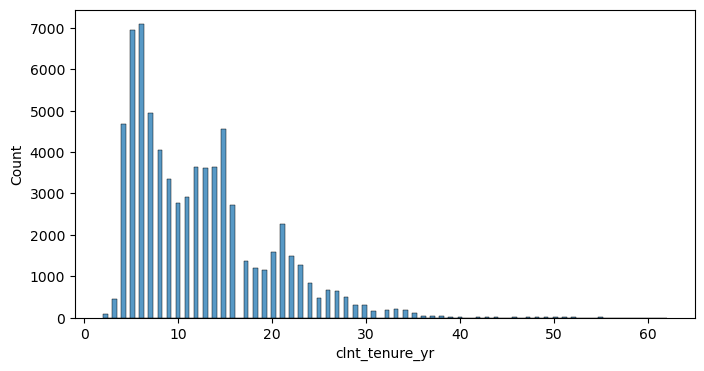

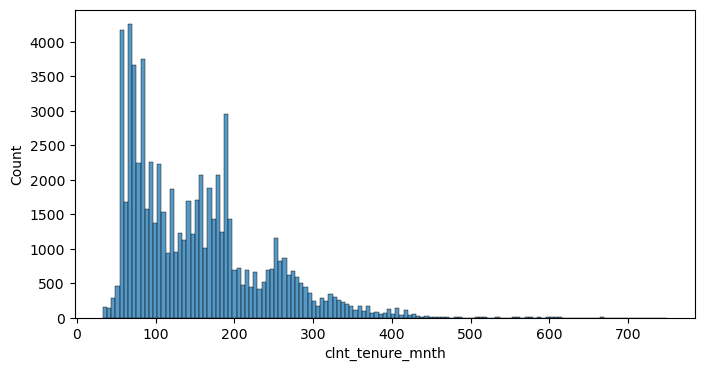

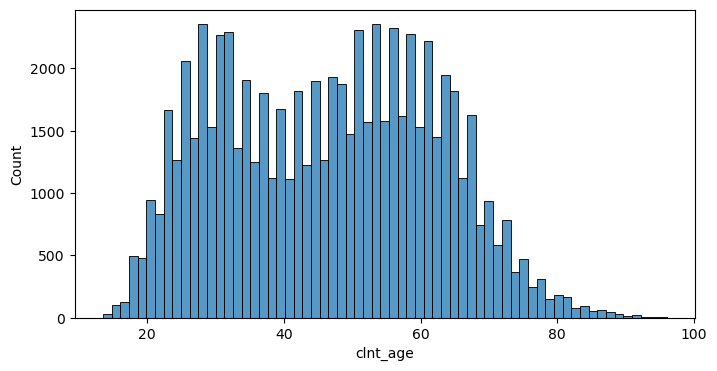

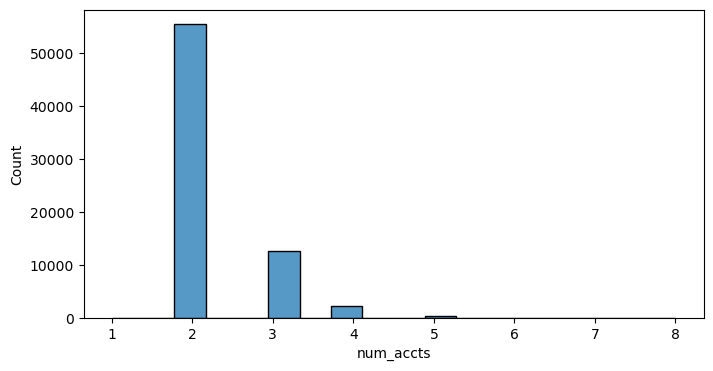

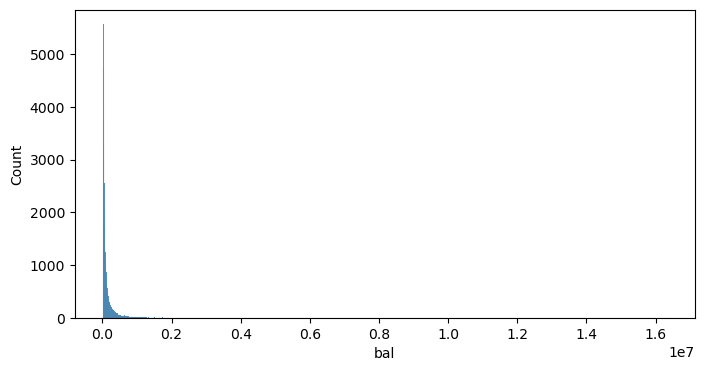

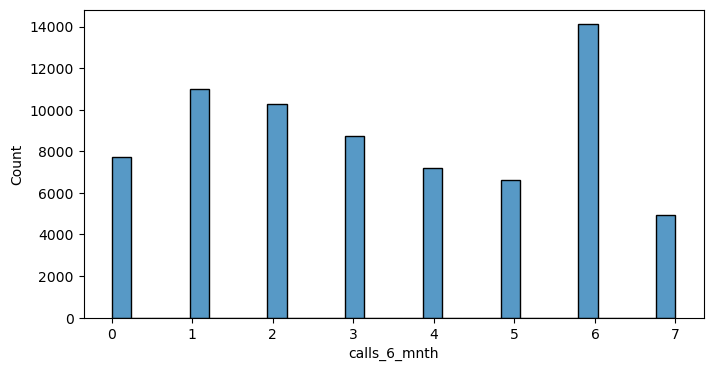

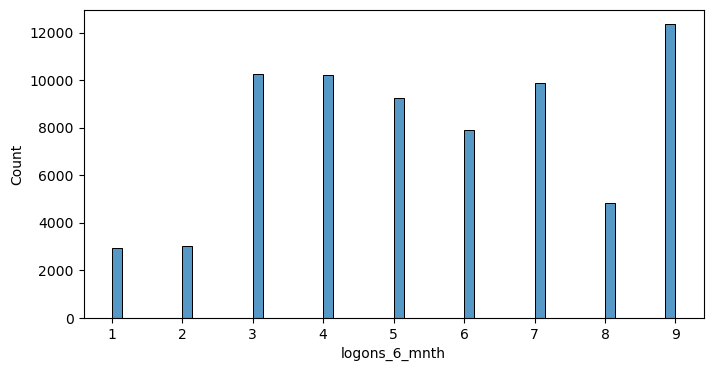

In [21]:
# visualise distributions for numerical columns.  

for col in clients_num:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=clients[col])
    plt.show()


C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_30952\3211288094.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(c['bal'], color='skyblue', shade=True)


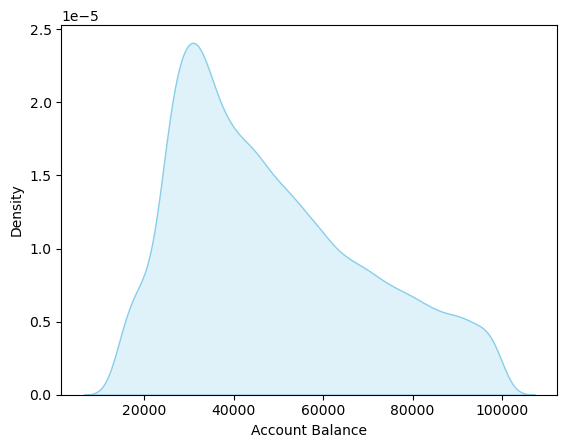

In [22]:
c = clients[clients['bal']<100000]
sns.kdeplot(c['bal'], color='skyblue', shade=True)
plt.xlabel('Account Balance')
plt.show()

### Events

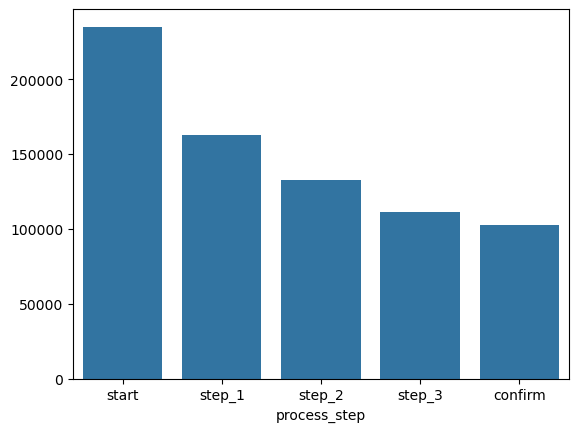

In [23]:
# Let's see how far in the funnel the users get

frequency_table = events["process_step"].value_counts()
frequency_table 

sns.barplot(x=frequency_table.index, y=frequency_table.values);

plt.show()

### Most active clients

In [24]:
# We will count the number of events to identify the most active clients. 
client_event_counts = events['client_id'].value_counts()
clients_events = pd.merge(clients, client_event_counts, on="client_id", how="inner")

In [25]:
# order clients by event_count
clients_events = clients_events.sort_values(by='count', ascending=False).reset_index(drop=True)

In [26]:
# Identify the top 10% of active clients (this can be changed to any other percentage if needed)
clients_events.head(int(len(clients_events) * 0.10))


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,count
0,2128341,12,153,52.5,F,2,176731.72,3,3,81
1,9800867,22,266,62.0,U,2,24449.73,6,6,75
2,465007,14,179,73.0,M,3,126442.72,6,9,72
3,9638063,33,406,78.0,F,2,87107.79,6,9,71
4,3539274,23,282,67.5,M,4,2797594.12,7,7,69
...,...,...,...,...,...,...,...,...,...,...
7054,8752868,7,84,72.5,U,2,153703.12,1,4,11
7055,9963921,7,84,55.5,U,2,25893.22,5,6,11
7056,6564602,9,113,53.0,M,2,83328.72,2,5,11
7057,5951127,9,111,42.5,M,2,58735.89,2,5,11


In [27]:
# we will signal those clients that are most active (top 10%).

clients_events['most_active'] = clients_events['client_id'].isin(clients_events['client_id'].head(int(len(clients_events) * 0.10)))

top_client_info = clients_events[clients_events['most_active'] == True]

In [28]:
age_analysis = top_client_info['clnt_age'].describe()
tenure_years_analysis = top_client_info['clnt_tenure_yr'].describe()
tenure_months_analysis = top_client_info['clnt_tenure_mnth'].describe()

print("Age Analysis:\n", age_analysis)
print("\nTenure (Years) Analysis:\n", tenure_years_analysis)
print("\nTenure (Months) Analysis:\n", tenure_months_analysis)

Age Analysis:
 count    7059.000000
mean       51.836733
std        15.576981
min        14.500000
25%        40.500000
50%        54.500000
75%        63.000000
max        94.000000
Name: clnt_age, dtype: float64

Tenure (Years) Analysis:
 count    7059.000000
mean       12.896869
std         7.368695
min         2.000000
25%         6.000000
50%        12.000000
75%        17.000000
max        55.000000
Name: clnt_tenure_yr, dtype: float64

Tenure (Months) Analysis:
 count    7059.000000
mean      160.668225
std        88.200626
min        33.000000
25%        83.000000
50%       146.000000
75%       214.000000
max       668.000000
Name: clnt_tenure_mnth, dtype: float64


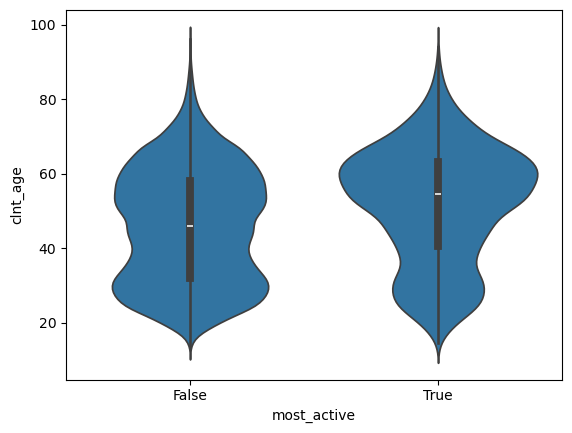

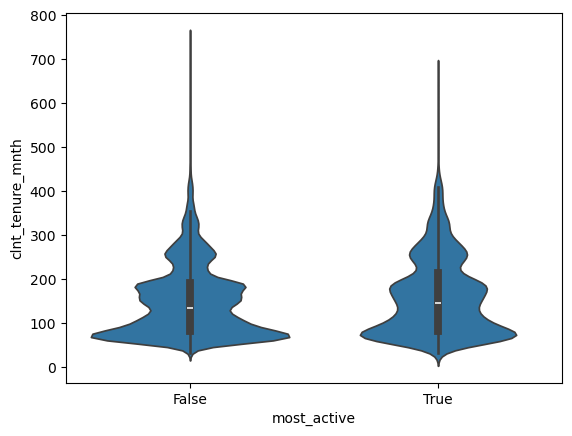

In [29]:
# Let's take a look at the distribution for age and tenure. 
for col in ['clnt_age', 'clnt_tenure_mnth']:
    sns.violinplot(data=clients_events, x='most_active', y=col)
    plt.show()

# the median age and tenure is higher for the most active clients.

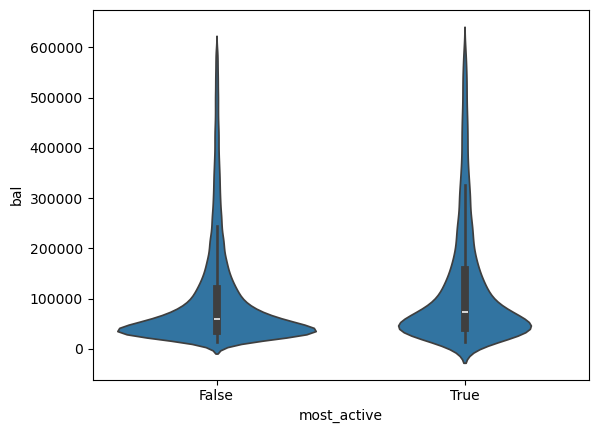

In [30]:
# There are very high outliers in balance. We will filter them out to see the distribution
sns.violinplot(data = clients_events [clients_events['bal'] < 600000], x='most_active', y='bal')
plt.show()

# the median balance is higher for most active users. 

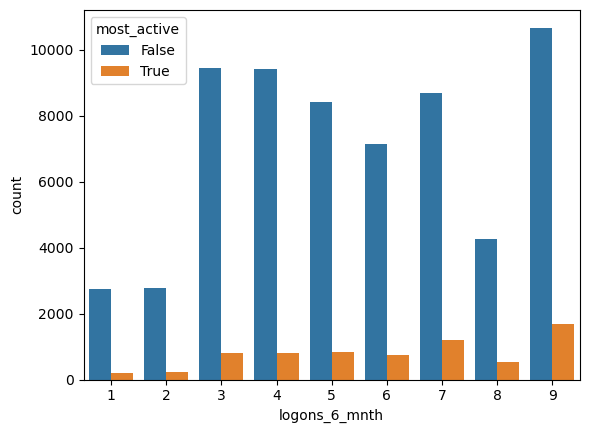

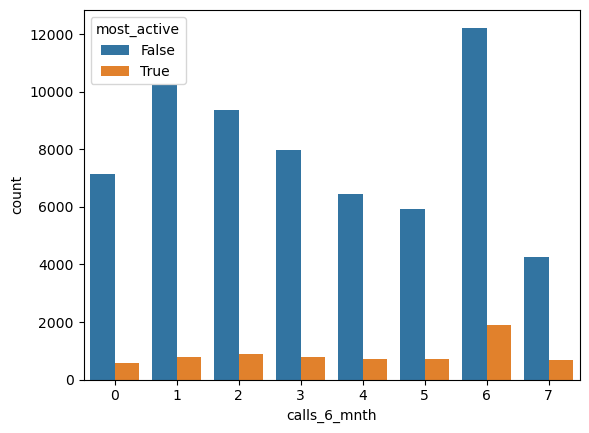

In [31]:
for col in ['logons_6_mnth', 'calls_6_mnth']:
    sns.countplot(data=clients_events, x=col, hue='most_active')
    plt.show()

## Behavior analysis

We want to analyse if the test affected the user behaviour. 
With that goal in mind we will some metrics that will later be used to compare the behaviour of those users that participated in the test o that were in the control group. 

**Key performance indicator**: 
- Users that "confirmed" the operation. 
Our main goal is to optimise the funnel to increase this metric. We will label this as "conversion". 

**Other metrics**: 
- Avg. visit duration. 
- Step duration. 
- Total errors. 
- Step errors. 
- Drop off step. 

In [33]:
import numpy as np
# Duration and step metrics. 

# turn the step column into a numeric value. 
events['init_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})

# shift the table to calculate the time spent in each step and the next step.
# we need to sort by visit_id and date_time first: 
events = events.sort_values(['visit_id', 'date_time']).reset_index()
events[['end_time', 'next_step']] = events[['visit_id', 'date_time','init_step']].groupby('visit_id').shift(-1)
events = events.rename(columns={'date_time':'init_time'})
events['next_step'] = events['next_step'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)

# get the time spent on each step
events['time_spent'] = (events['end_time']-events['init_time']).dt.total_seconds()

# get the 'progress' (difference between the next step and the current step)
events['progress'] = events['next_step'] - events['init_step']


C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_30952\1521861496.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['init_step'] = events['process_step'].replace({'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4})


In [34]:
# change columns order to make them easier to read. 
events = events[['client_id', 'visitor_id', 'visit_id', 'process_step', 'init_time', 'end_time', 'time_spent', 'init_step', 'next_step', 'progress']]

events.head()

,client_id,visitor_id,visit_id,process_step,init_time,end_time,time_spent,init_step,next_step,progress
0,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,2017-04-26 13:23:09,52.0,4,4.0,0.0
1,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,NaT,NaN,4,NaN,NaN
2,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29,2017-06-04 01:07:32,3.0,0,1.0,1.0
3,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32,2017-06-04 01:07:56,24.0,1,2.0,1.0
4,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56,2017-06-04 01:09:13,77.0,2,3.0,1.0


In [35]:
# We will now add the client demographic info and calculate metrics per client. 

test_metrics = pd.merge(test, clients, on='client_id', how='inner')

# add last step to test df
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['init_step'].max().reset_index(name='last_step'), on='client_id', how='left')

# add converstion to test df  
# the value will be 1 if the user completed the process and 0 if they did not.
test_metrics['conversion'] = (test_metrics['last_step'] == 4)

# get the number of events per client
test_metrics = pd.merge(test_metrics, events.groupby('client_id').size().reset_index(name='event_count'), on='client_id', how='left')

# get the average time spent in each step per client
test_metrics = pd.merge(test_metrics, events.groupby('client_id')['time_spent'].mean().reset_index(name='avg_step_time'), on='client_id', how='left')

# get the number of errors (progress < 0) per client 
test_metrics = pd.merge(test_metrics, events[events['progress'] < 0].groupby('client_id').size().reset_index(name='error_count'), on='client_id', how='left')


In [36]:
# let's manage null values.

test_metrics.isnull().sum()


client_id               0
Variation               0
clnt_tenure_yr          0
clnt_tenure_mnth        0
clnt_age                0
gendr                   0
num_accts               0
bal                     0
calls_6_mnth            0
logons_6_mnth           0
last_step               0
conversion              0
event_count             0
avg_step_time        3934
error_count         35084
dtype: int64

In [37]:
# we have deteremined that null values in error_count correspond to users that didn't have any erros. 
test_metrics.error_count.fillna(0, inplace=True)

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_30952\1061312808.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_metrics.error_count.fillna(0, inplace=True)


In [38]:
test_metrics[test_metrics.avg_step_time.isnull()]['last_step'].value_counts()

last_step
0    3776
4     137
1      16
3       4
2       1
Name: count, dtype: int64

In [82]:
test_metrics2 = test_metrics[(~(test_metrics.avg_step_time.isnull()) | (test_metrics['last_step'] == 0))]

In [84]:
test_metrics2[test_metrics2.avg_step_time.isnull()]['last_step'].value_counts()

last_step
0    3776
Name: count, dtype: int64

In [85]:
len(test_metrics)

50487

In [122]:
#let's find null values
test_metrics.isnull().sum()

#these values indicate that the user didn't spend time on the steps. Let's replace them with 0.
test_metrics.fillna(0, inplace=True)
test_metrics.head()

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,last_step,conversion,event_count,avg_step_time,error_count
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4,3,False,15,590.846154,2.0
1,8320017,Test,22,274,34.5,M,2,36001.90,5,8,4,True,5,29.750000,0.0
2,4033851,Control,12,149,63.5,M,2,142642.26,5,8,4,True,15,107.357143,3.0
3,1982004,Test,6,80,44.5,U,2,30231.76,1,4,4,True,5,45.000000,0.0
4,9294070,Control,5,70,29.0,U,2,34254.54,0,3,0,False,2,15.000000,0.0


In [124]:
#let's find null values
test_metrics.isnull().sum()

client_id           0
Variation           0
clnt_tenure_yr      0
clnt_tenure_mnth    0
clnt_age            0
gendr               0
num_accts           0
bal                 0
calls_6_mnth        0
logons_6_mnth       0
last_step           0
conversion          0
event_count         0
avg_step_time       0
error_count         0
dtype: int64

### Control vs Test

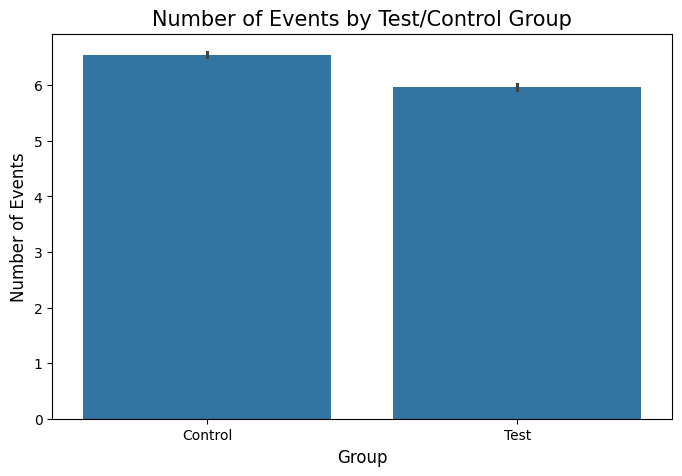

In [593]:
# Plot the number of events for Test vs Control groups
plt.figure(figsize=(8, 5))
sns.barplot(x='Variation', y='event_count', data=test_metrics)
plt.title('Number of Events by Test/Control Group', fontsize=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks([0, 1], ['Control', 'Test'])
plt.show()

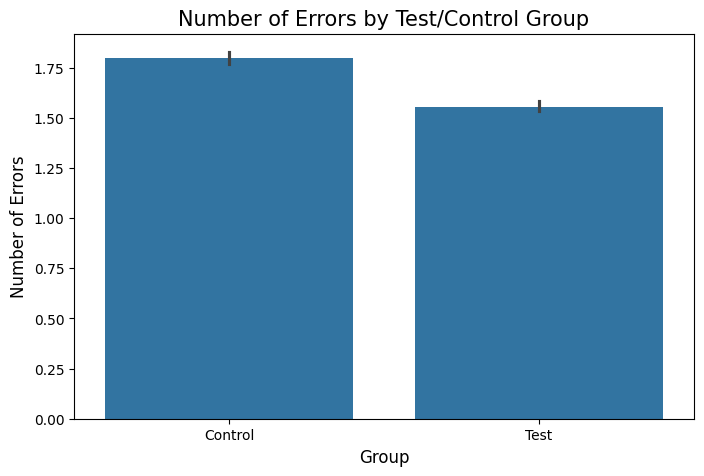

In [592]:
# Plot the number of errors for Test vs Control groups
plt.figure(figsize=(8, 5))
sns.barplot(x='Variation', y='error_count', data=test_metrics)
plt.title('Number of Errors by Test/Control Group', fontsize=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of Errors', fontsize=12)
plt.xticks([0, 1], ['Control', 'Test'])
plt.show()



In [200]:
crosstab_result = pd.crosstab(test['Variation'], test['conversion'])

crosstab_result

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value
chi2_p_value < 0.05

(np.float64(78.5879813123307), np.float64(7.651350968671897e-19))